<a href="https://colab.research.google.com/github/erendagasan/Eren-Dagasan-Personal/blob/main/ARMIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.7 MB/s eta 0:00:00


In [51]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = yf.download("EXPE", start="2006-01-01", end="2023-09-10")
stock_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,48.000000,48.400002,46.900002,48.000000,31.614485,1029700
2006-01-04,48.000000,48.599998,47.180000,48.500000,31.943800,1135550
2006-01-05,48.660000,48.700001,47.599998,48.000000,31.614485,618850
2006-01-06,48.480000,48.680000,47.220001,48.020000,31.627663,1600500
2006-01-09,48.080002,49.020000,47.599998,48.840000,32.167747,1079550
...,...,...,...,...,...,...
2023-09-01,109.230003,109.980003,108.230003,109.570000,109.570000,1593600
2023-09-05,109.400002,111.470001,108.540001,110.220001,110.220001,2004100
2023-09-06,109.190002,109.709999,105.930000,108.410004,108.410004,2368900


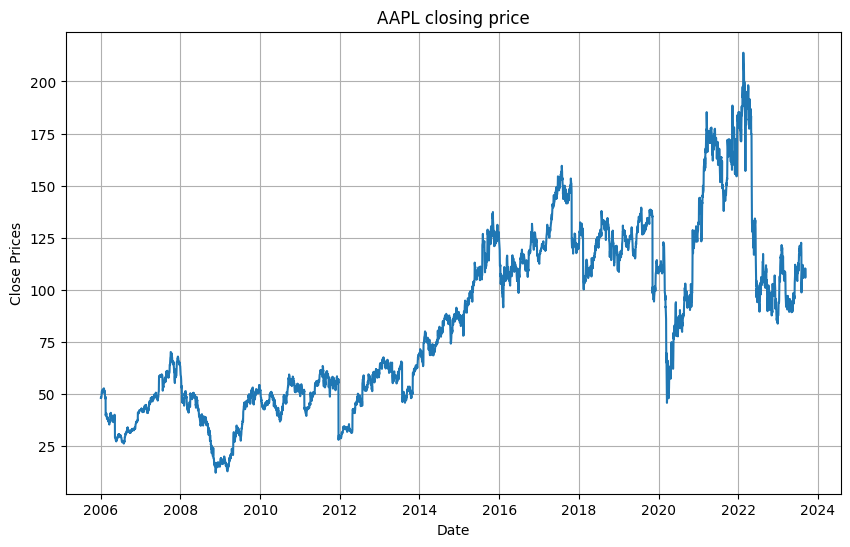

In [52]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('AAPL closing price')
plt.show()

<Axes: ylabel='Density'>

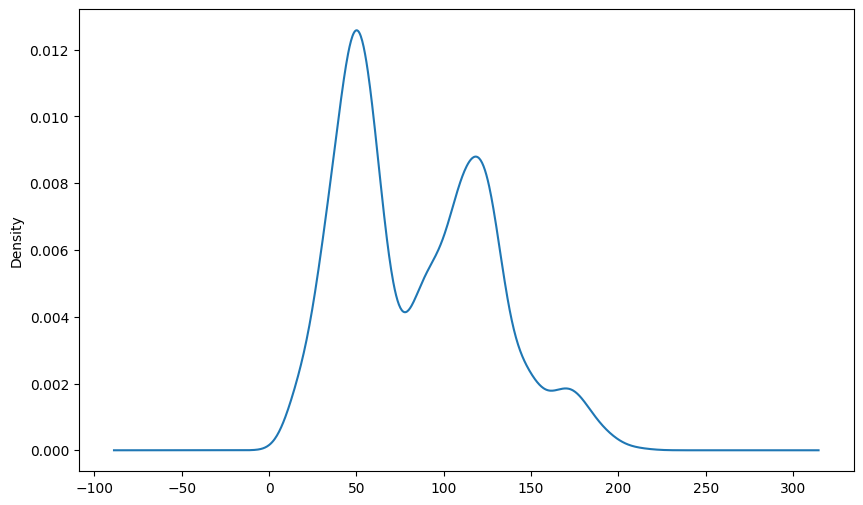

In [53]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

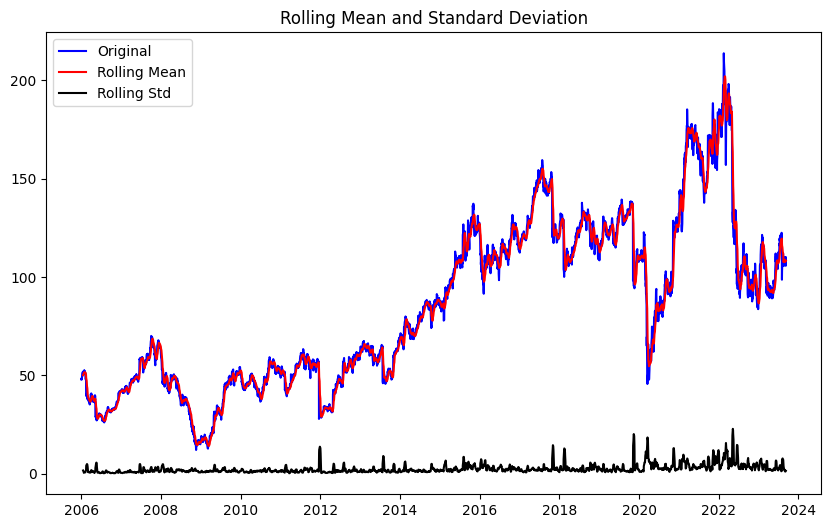

Results of dickey fuller test
Test Statistics                  -1.743280
p-value                           0.408963
No. of lags used                 17.000000
Number of observations used    4433.000000
critical value (1%)              -3.431826
critical value (5%)              -2.862192
critical value (10%)             -2.567117
dtype: float64


In [54]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 1000x600 with 0 Axes>

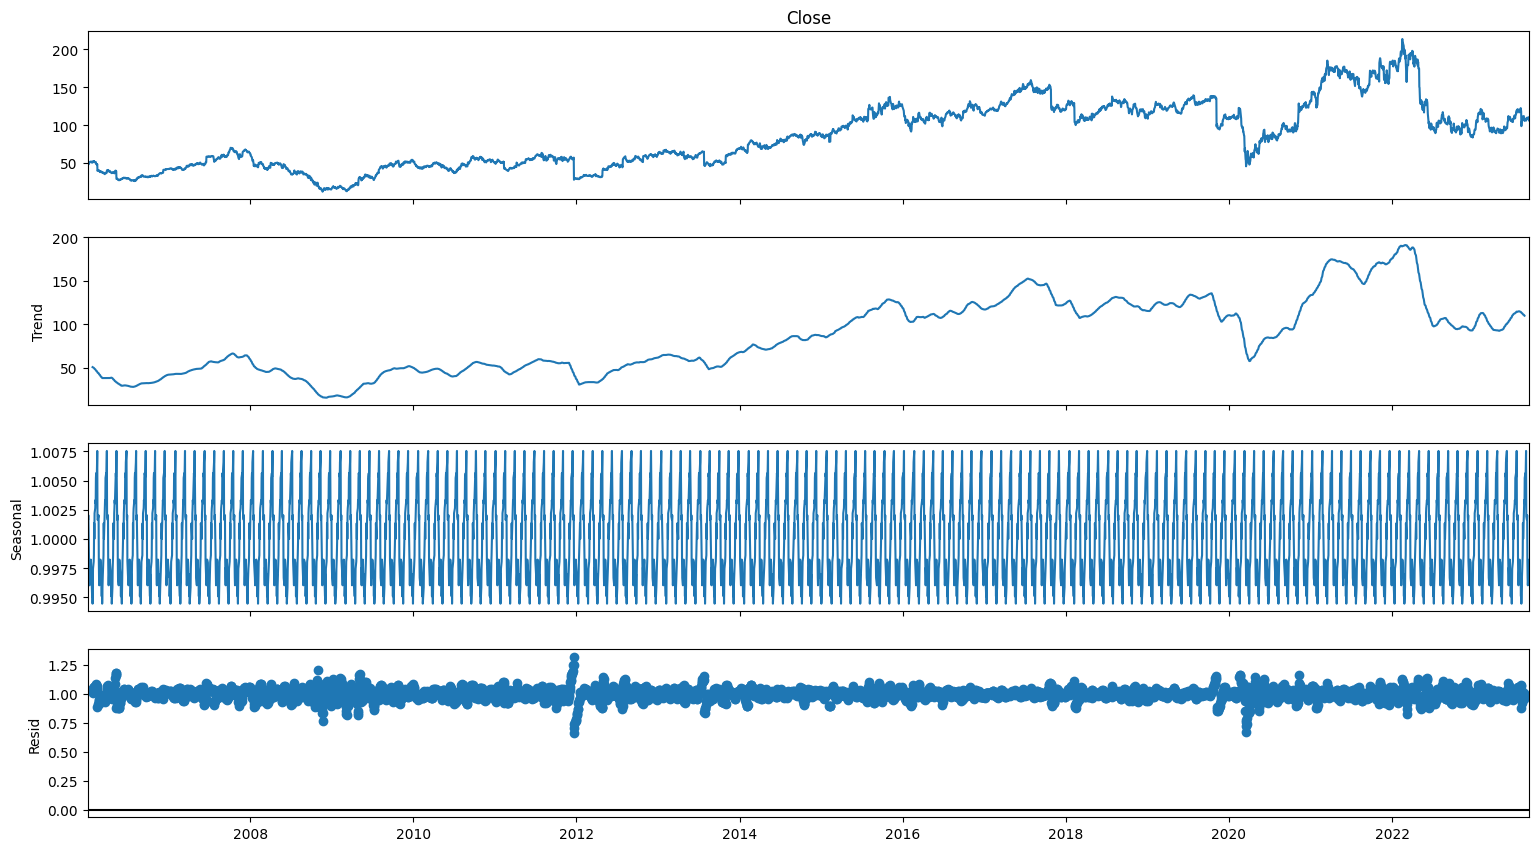

In [55]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

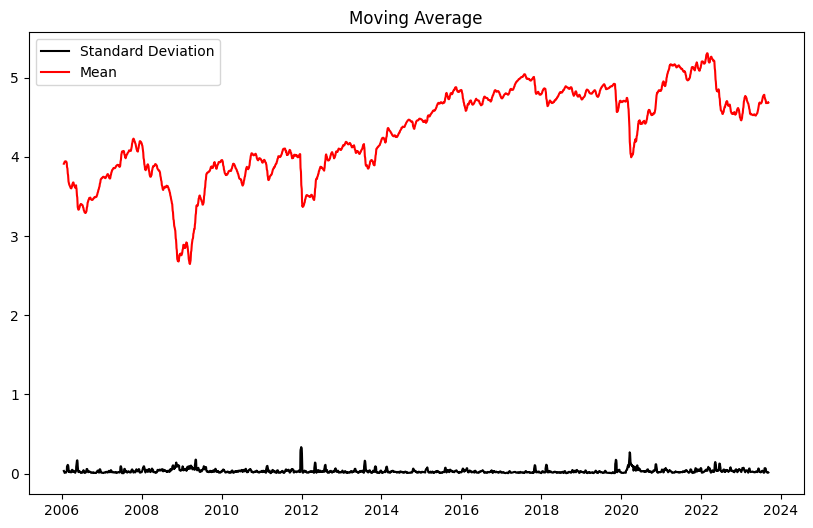

In [56]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

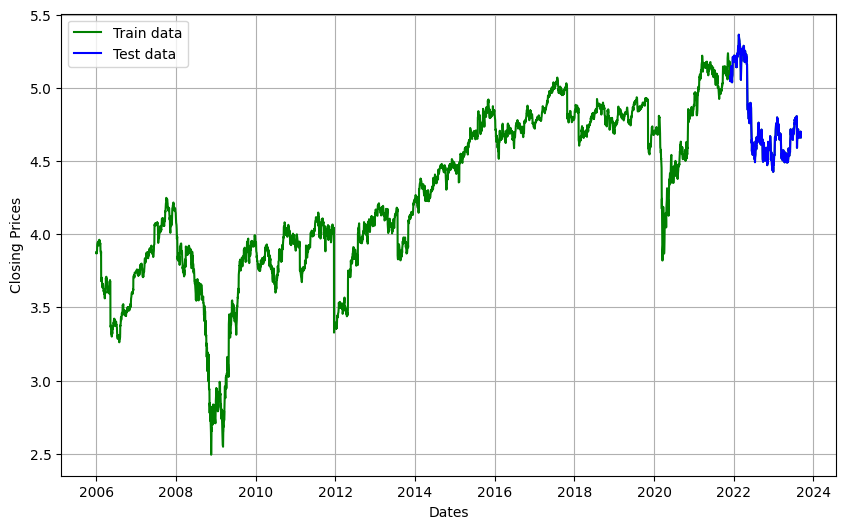

In [57]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=23007.009, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.77 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-16681.471, Time=2.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=3.76 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-16679.486, Time=2.47 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=12357.329, Time=0.69 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=2.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=2.72 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-16686.054, Time=0.38 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1445.133, Time=0.86 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-16683.561, Time=1.87 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-16684.085, Time=2.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6707.090,

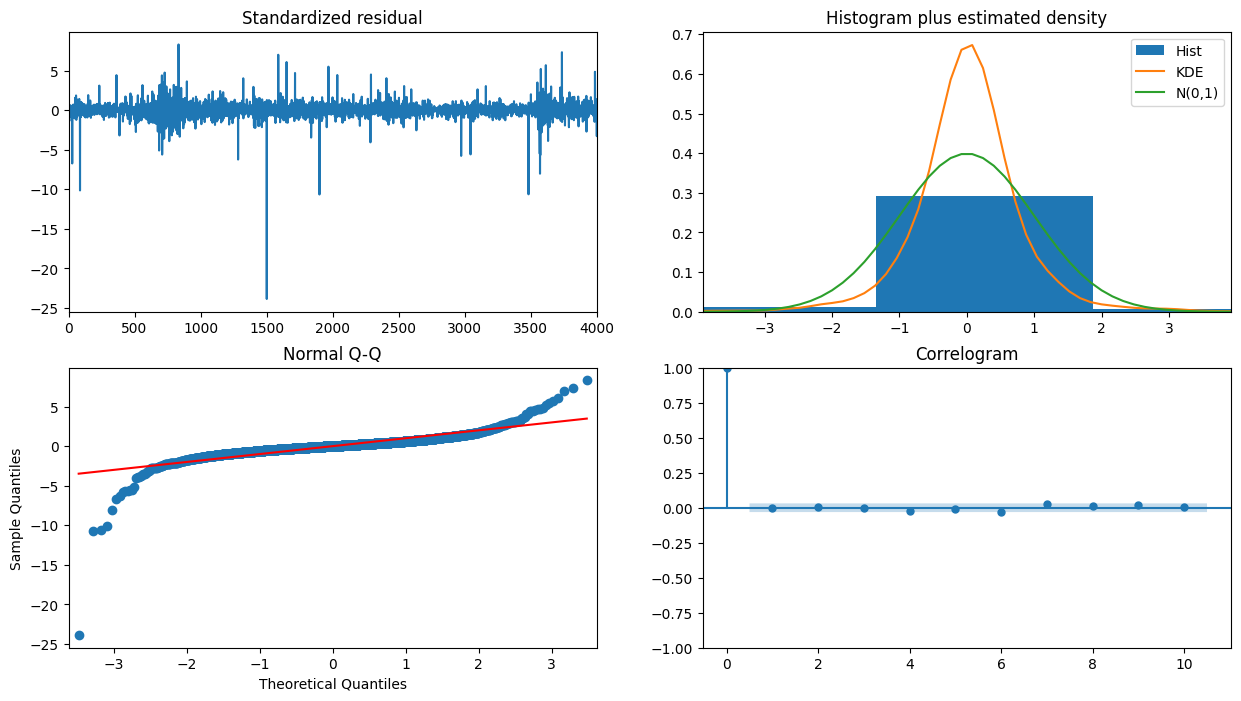

In [58]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [60]:
from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 0, 1))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4002
Model:                 ARIMA(1, 0, 1)   Log Likelihood                8347.001
Date:                Tue, 12 Sep 2023   AIC                         -16686.003
Time:                        20:33:23   BIC                         -16660.825
Sample:                             0   HQIC                        -16677.078
                               - 4002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2489      0.421     10.085      0.000       3.423       5.075
ar.L1          0.9988      0.001   1346.867      0.000       0.997       1.000
ma.L1         -0.0060      0.012     -0.506      0.6

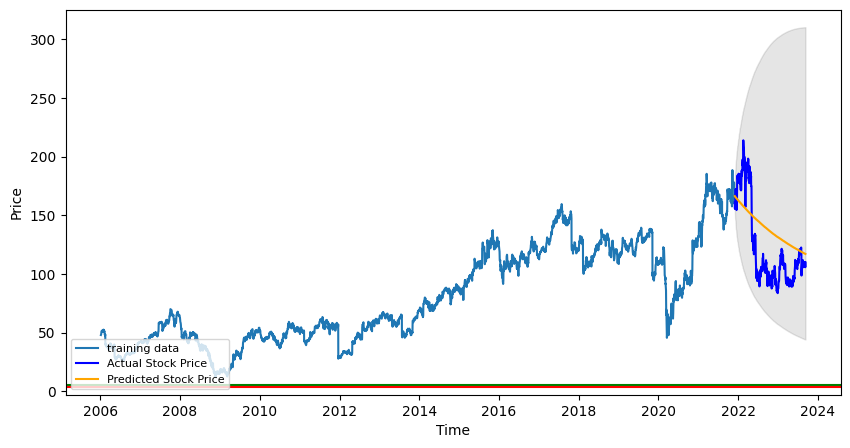

In [61]:
forecast_results = fitted.get_forecast(steps=len(test_data), alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color='blue', label='Actual Stock Price')
plt.plot(test_data.index, np.exp(fc), color='orange', label='Predicted Stock Price')  # Convert back to original scale
plt.fill_between(test_data.index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]),
                 color='k', alpha=.10)

plt.axhline(conf.iloc[:, 1].max(), color="green")
plt.axhline(conf.iloc[:, 0].min(), color="red")

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='lower left', fontsize=8)
plt.show()

In [35]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc.to_numpy() - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.010629261275016148
MAE: 0.0871995557368755
RMSE: 0.10309830878834118
MAPE: 0.017213829203243585


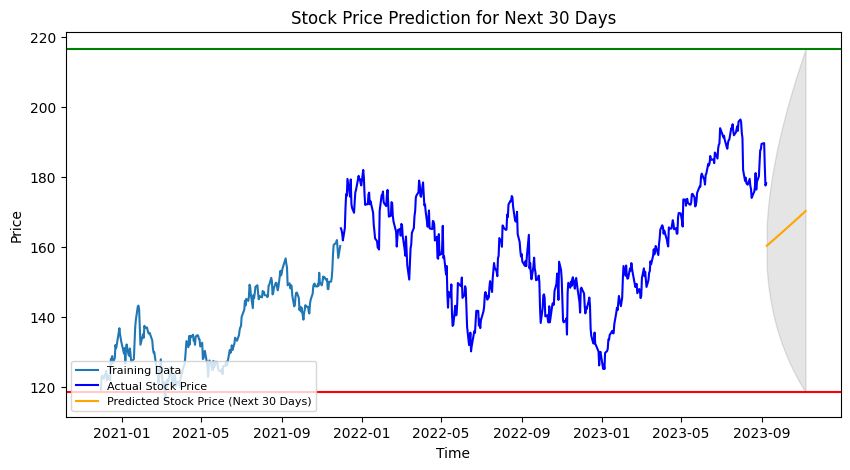

Forecasted Prices for Next 30 Days:
4002    160.294988
4003    160.458488
4004    160.622155
4005    160.785988
4006    160.949989
4007    161.114157
4008    161.278492
4009    161.442995
4010    161.607666
4011    161.772505
4012    161.937511
4013    162.102687
4014    162.268030
4015    162.433543
4016    162.599224
4017    162.765074
4018    162.931093
4019    163.097282
4020    163.263640
4021    163.430168
4022    163.596865
4023    163.763733
4024    163.930771
4025    164.097979
4026    164.265358
4027    164.432908
4028    164.600628
4029    164.768520
4030    164.936583
4031    165.104817
4032    165.273223
4033    165.441800
4034    165.610550
4035    165.779471
4036    165.948565
4037    166.117832
4038    166.287271
4039    166.456883
4040    166.626668
4041    166.796626
4042    166.966757
4043    167.137062
4044    167.307541
4045    167.478193
4046    167.649020
4047    167.820021
4048    167.991196
4049    168.162546
4050    168.334071
4051    168.505770
4052    168.67

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Generate dates for the next 30 days
last_date = test_data.index[-1]
next_30_days = pd.date_range(start=last_date, periods=61, closed='right')

# Extend the forecast for the next 30 days
forecasted_next_30_days = np.exp(model_autoARIMA.predict(n_periods=60))  # Convert back to original scale

# Calculate confidence intervals for the next 30 days' forecast
forecast_results = fitted.get_forecast(steps=60, alpha=0.05)
fc = np.exp(forecast_results.predicted_mean)  # Convert back to original scale
conf = np.exp(forecast_results.conf_int())     # Convert back to original scale

# Plot the forecasted prices for the next 30 days along with confidence intervals
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data[3750:]), label='Training Data')
plt.plot(np.exp(test_data), color='blue', label='Actual Stock Price')
plt.plot(next_30_days, forecasted_next_30_days, color='orange', label='Predicted Stock Price (Next 30 Days)')

plt.axhline(conf.iloc[:, 1].max(), color="green")
plt.axhline(conf.iloc[:, 0].min(), color="red")

# Fill between the confidence intervals for the next 30 days' forecast
plt.fill_between(next_30_days, conf.iloc[:, 0], conf.iloc[:, 1], color='k', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='lower left', fontsize=8)
plt.title('Stock Price Prediction for Next 30 Days')
plt.show()

# Optionally, you can calculate and print the forecasted prices for the next 30 days
print("Forecasted Prices for Next 30 Days:")
print(forecasted_next_30_days)